In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import re

from imblearn.over_sampling import SMOTE
from collections import Counter
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm_notebook as tqdm
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
!python -m spacy download ru_core_news_lg

2022-11-25 09:17:26.403117: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 513.4 MB 15 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


In [ ]:
nlp = spacy.load("ru_core_news_lg")
nlp.disable_pipes('ner', 'parser', 'attribute_ruler')
nlp.add_pipe('sentencizer')
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'lemmatizer', 'sentencizer']


In [ ]:
df = pd.read_csv('Rzd_official_labeled.csv', sep=';', encoding='utf8')
df

,Column1,date,text,label
0,0.0,31.12.2019,Почему закрыта тема с отзывами? Российские жел...,negative
1,1.0,31.12.2019,"Хочу выразить благодарность проводнице Ольге, ...",positive
2,2.0,02.01.2020,"хорошая техподдержка, ответы развёрнутые.",positive
3,3.0,03.01.2020,Очень понравилось на поезде было 30.12.2019,positive
4,4.0,04.01.2020,"К сожалению, у меня сложное аутоиммунное забол...",negative
...,...,...,...,...
785,784.0,28.12.2021,РЖД какими вы были такими и остались ! ехали п...,negative
786,785.0,29.12.2021,Как можно разрешить провозить животных в купе ...,negative
787,786.0,30.12.2021,"Добрый день, всегда уезжаем с Курского вокзала...",negative
788,787.0,31.12.2021,"Не очень люблю поезда, особенно плацкарт , но ...",positive


In [ ]:
df['label'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [ ]:
labels = {'negative': 0, 'neutral' : 1, 'positive': 2}
enc = LabelEncoder()
df['label'] = enc.fit_transform(df['label'])
df = df.drop('Column1', axis=1)
df = df.drop('date', axis=1)
df

,text,label
0,Почему закрыта тема с отзывами? Российские жел...,0
1,"Хочу выразить благодарность проводнице Ольге, ...",2
2,"хорошая техподдержка, ответы развёрнутые.",2
3,Очень понравилось на поезде было 30.12.2019,2
4,"К сожалению, у меня сложное аутоиммунное забол...",0
...,...,...
785,РЖД какими вы были такими и остались ! ехали п...,0
786,Как можно разрешить провозить животных в купе ...,0
787,"Добрый день, всегда уезжаем с Курского вокзала...",0
788,"Не очень люблю поезда, особенно плацкарт , но ...",2


In [ ]:
all_words = [] # list for all words in all texts
for row_index, row in tqdm(df.iterrows()):

  text = row['text']
  clear = re.findall('[а-я]+', text.lower()) # all words in one text

  for i, word in enumerate(clear):
    word_processed = nlp(word)[0]
    if word_processed.pos_ not in ['VERB', 'NOUN', 'ADJ', 'ADV']:
      clear.remove(word)
    else:
      clear[i] = word_processed.lemma_

  all_words.extend(clear)
      
  clear = ' '.join(clear)
  df.loc[row_index, 'text'] = clear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

In [ ]:
word_count = Counter(all_words)
len(word_count)

8021

In [ ]:
all_words = [i[0] for i in word_count.most_common(500)]

In [ ]:
def get_embeddings(doc):
    text_embeddings = []
    for sent in doc.sents:
        sent_embeddings = []
        for token in sent:
              sent_embeddings.append(token.vector)
        text_embeddings.append(np.mean(sent_embeddings, axis=0))
    text_embeddings = np.mean(text_embeddings, axis=0)
    if np.isnan(text_embeddings[0]):
        text_embeddings = [0 for _ in range(300)]
    return text_embeddings

In [ ]:
columns = ['target']
columns.extend(all_words)
for i in range(300):
    columns.append('emb'+ str(i))
score_df = pd.DataFrame(columns = columns)
for row in tqdm(df.iterrows()):
    text = row[1]['text']
    doc = nlp(text)
    lemmas = [i.lemma_ for i in doc if i.pos_ in ['VERB', 'NOUN', 'ADV', 'ADJ']]
    embedding = get_embeddings(doc)
    one_hot_text = [1 if i in lemmas else 0 for i in all_words]
    numeric = [row[1]['label']]
    numeric.extend(one_hot_text)
    numeric.extend(embedding)
    score_df.loc[len(score_df)] = numeric

score_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

,target,поезд,вагон,проводник,очень,благодарность,спасибо,хотеть,не,в,...,emb290,emb291,emb292,emb293,emb294,emb295,emb296,emb297,emb298,emb299
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.045460,-0.068559,-0.030959,-0.024467,0.020314,-0.160923,-0.069225,-0.175035,-0.037439,0.052298
1,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.023849,0.004964,0.004210,0.050953,0.010695,-0.221054,-0.108816,-0.237614,-0.106503,0.132935
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018695,0.035979,0.014072,0.185444,0.085146,-0.171517,-0.039567,-0.111265,-0.070034,0.120835
3,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.168371,-0.030380,0.173095,0.079510,0.072834,-0.106007,-0.105059,-0.023677,0.091557,0.194914
4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.000745,-0.037812,-0.077435,0.020428,0.090344,-0.214100,-0.011916,-0.180986,-0.074604,0.145378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.154474,-0.137270,-0.021424,-0.035891,0.006573,-0.109320,-0.134124,-0.290725,0.053059,0.115337
786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.028848,0.011739,-0.019917,0.021451,0.030988,-0.140008,-0.129000,-0.185136,-0.164137,0.114840
787,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.006594,0.011808,-0.030605,0.022256,0.115727,-0.115152,-0.057741,-0.201017,-0.017311,0.140642
788,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.014980,-0.041963,-0.014230,0.046424,0.181378,-0.206884,-0.046992,-0.214419,-0.030889,0.142722


In [ ]:
label = score_df['target']
data = score_df.drop(columns=['target'])
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)
Counter(label)

Counter({0.0: 315, 2.0: 420, 1.0: 55})

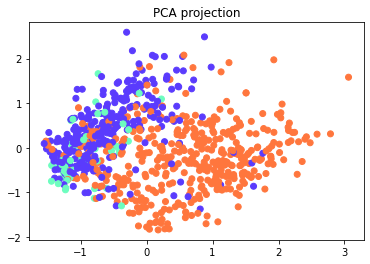

In [ ]:
pca = PCA(n_components=2)
d2 = pca.fit_transform(data)
color_palette = sns.color_palette('rainbow', 12)

plt.scatter(
    d2[:, 0],
    d2[:, 1],
    c= [color_palette[int(x) * 5] for x in label])
plt.title('PCA projection', fontsize=12)
plt.show()

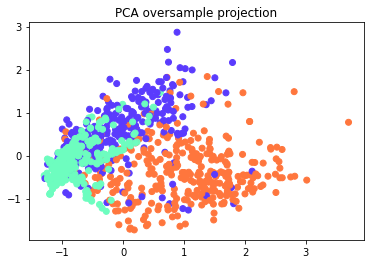

In [ ]:
oversample = SMOTE()
oversample_x, oversample_y = oversample.fit_resample(train_x, train_y)

pca = PCA(n_components=2)
d2 = pca.fit_transform(oversample_x)
color_palette = sns.color_palette('rainbow', 12)

plt.scatter(
    d2[:, 0],
    d2[:, 1],
    c= [color_palette[int(x) * 5] for x in oversample_y])
plt.title('PCA oversample projection', fontsize=12)
plt.show()

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(train_x.shape[1]))
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               102528    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 110,979
Trainable params: 110,979
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_x, train_y, epochs=5, batch_size=32)

Epoch 1/5
20/20 [==============================] - 1s 4ms/step - loss: 0.7874 - accuracy: 0.6867
Epoch 2/5
20/20 [==============================] - 0s 4ms/step - loss: 0.4887 - accuracy: 0.8386
Epoch 3/5
20/20 [==============================] - 0s 3ms/step - loss: 0.3994 - accuracy: 0.8639
Epoch 4/5
20/20 [==============================] - 0s 4ms/step - loss: 0.3181 - accuracy: 0.8892
Epoch 5/5
20/20 [==============================] - 0s 3ms/step - loss: 0.2547 - accuracy: 0.9114


In [ ]:
pred_y = model.predict(test_x)
prediction = np.argmax(pred_y, axis=1)

5/5 [==============================] - 0s 3ms/step


In [ ]:
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

         0.0       0.79      0.82      0.81        61
         1.0       1.00      0.20      0.33        15
         2.0       0.84      0.94      0.89        82

    accuracy                           0.82       158
   macro avg       0.88      0.65      0.67       158
weighted avg       0.84      0.82      0.80       158



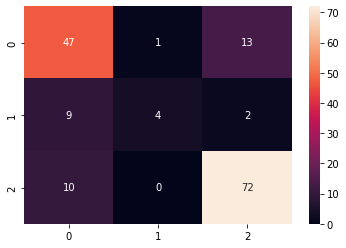

In [ ]:
sns.heatmap(confusion_matrix(test_y, prediction), annot=True)

In [ ]:
embedding_start_index = 300
train_emb = train_x.iloc[:,embedding_start_index:]
train_oh = train_x.iloc[:,:embedding_start_index]
test_emb = test_x.iloc[:,embedding_start_index:]
test_oh = test_x.iloc[:,:embedding_start_index]

In [ ]:
test_emb.shape, train_oh.shape

((158, 500), (632, 300))

In [ ]:
one_hot_in = tf.keras.Input(shape=(train_oh.shape[1],), name='one_hot')
one_hot_hidden = keras.layers.Dense(64, name='one_hot_hidden')(one_hot_in)

embeddings_in = keras.Input(shape=(train_emb.shape[1],), name='embedding')
embeddings_hidden = keras.layers.Dense(64, name='embeddings_hidden')(embeddings_in)


conc = keras.layers.concatenate([embeddings_hidden, one_hot_hidden], name='conc')
conc_hidden = keras.layers.Dense(64, name='all_hidden')(conc)
conc_dropout = keras.layers.Dropout(.2, name='dropout')(conc_hidden)
final = keras.layers.Dense(3, name='out', activation = 'softmax')(conc_dropout)

model_v2 = keras.Model(
    inputs=[one_hot_in, embeddings_in],
    outputs=[final],
)
model_v2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 one_hot (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embeddings_hidden (Dense)      (None, 64)           32064       ['embedding[0][0]']              
                                                                                                  
 one_hot_hidden (Dense)         (None, 64)           19264       ['one_hot[0][0]']                
                                                                                            

In [ ]:
model_v2.compile(
    optimizer= 'adam',
    loss=[
        keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    ],
    metrics = ['accuracy']
)

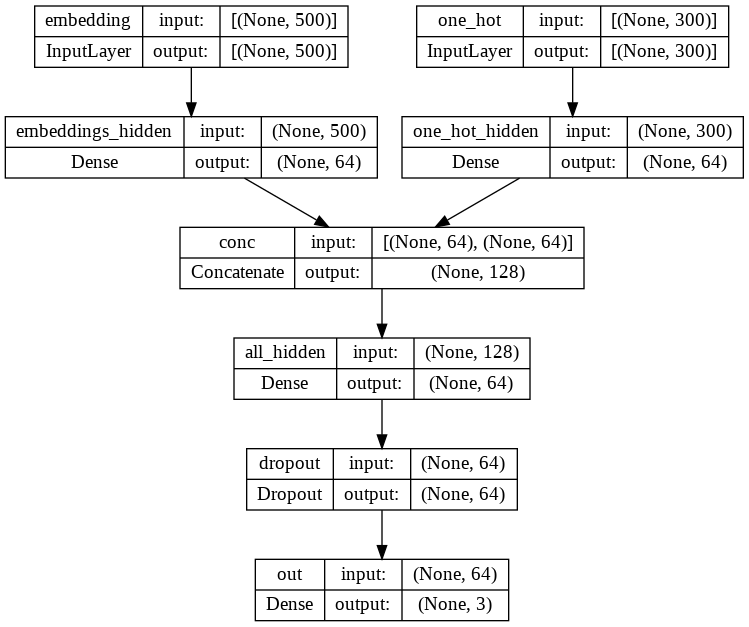

In [ ]:
keras.utils.plot_model(model_v2, show_shapes=True)

In [ ]:
model_v2.fit({'one_hot': train_oh, 'embedding': train_emb}, {'out': train_y}, epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 1s 3ms/step - loss: 0.7842 - accuracy: 0.6614
Epoch 2/5
20/20 [==============================] - 0s 3ms/step - loss: 0.4867 - accuracy: 0.8354
Epoch 3/5
20/20 [==============================] - 0s 3ms/step - loss: 0.4188 - accuracy: 0.8576
Epoch 4/5
20/20 [==============================] - 0s 3ms/step - loss: 0.3432 - accuracy: 0.8734
Epoch 5/5
20/20 [==============================] - 0s 3ms/step - loss: 0.2917 - accuracy: 0.8987


In [ ]:
res = model_v2.predict({'one_hot': test_oh, 'embedding': test_emb})
for i, el in enumerate(res):
    res[i] = np.argmax(el)
res = res[:,0]

5/5 [==============================] - 0s 3ms/step


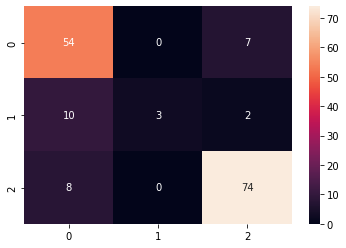

In [ ]:
sns.heatmap(confusion_matrix(test_y, res), annot=True)

In [ ]:
print(classification_report(test_y, res)) # functional API (60K params)

              precision    recall  f1-score   support

         0.0       0.75      0.89      0.81        61
         1.0       1.00      0.20      0.33        15
         2.0       0.89      0.90      0.90        82

    accuracy                           0.83       158
   macro avg       0.88      0.66      0.68       158
weighted avg       0.85      0.83      0.81       158



In [ ]:
print(classification_report(test_y, prediction)) # sequential (111K params)

              precision    recall  f1-score   support

         0.0       0.79      0.82      0.81        61
         1.0       1.00      0.20      0.33        15
         2.0       0.84      0.94      0.89        82

    accuracy                           0.82       158
   macro avg       0.88      0.65      0.67       158
weighted avg       0.84      0.82      0.80       158

